In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min width:70px;}
div#toc-wrapper {padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe {font-size:12px;}
</style>
"""))

<font size='6' color='red'><b>ch4 RNN(Recurrent Neural Network : 순환신경망)</b></font>
- 데이터의 순서가 중요하거나, 시계열 데이터일 경우
- 활용분야 : 번역, 음성인식, 주가예측, 가격예측

# 1. 문맥을 이용하여 모델만들기

In [2]:
text =  """경마장에 있는 말이 뛰고 있고\n
그의 말이 법이다 \n
가는 말이 고와야 오는 말이 곱다 \n"""
text1 = "겨울이 오는 날"

In [3]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text, text1])
encoded = t.texts_to_sequences([text, text1])
print(encoded)
print(t.word_index)

[[3, 4, 1, 5, 6, 7, 1, 8, 9, 1, 10, 2, 1, 11], [12, 2, 13]]
{'말이': 1, '오는': 2, '경마장에': 3, '있는': 4, '뛰고': 5, '있고': 6, '그의': 7, '법이다': 8, '가는': 9, '고와야': 10, '곱다': 11, '겨울이': 12, '날': 13}


In [4]:
t.texts_to_sequences(['경마장에 있는 말이 뛰고'])[0]

[3, 4, 1, 5]

In [5]:
text =  """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""

In [6]:
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])
print(encoded)
print(t.word_index)

[[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [7]:
for key, value in t.word_index.items():
    print(key, value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [8]:
# text를 학습시키기 위해, ['경마장에 있는', '경마장에 있는 말이', ....]
sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    print('원문장 :', line, ', 인코딩된 문장 :', encoded)
    for i in range(0, len(encoded)-1):
        for j in range(i+2, len(encoded)+1):
            sequences.append(encoded[i:j])

원문장 : 경마장에 있는 말이 뛰고 있다 , 인코딩된 문장 : [2, 3, 1, 4, 5]
원문장 : 그의 말이 법이다 , 인코딩된 문장 : [6, 1, 7]
원문장 : 가는 말이 고와야 오는 말이 곱다 , 인코딩된 문장 : [8, 1, 9, 10, 1, 11]


In [9]:
print('sequences와 해석')
for sequence in sequences:
    for word_seq in sequence:
        for key,value in t.word_index.items():
            if word_seq == value:
                print("{}:{}".format(word_seq, key), end=' ')
                break;
    print()

sequences와 해석
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [10]:
my_len = max([len(sequence) for sequence in sequences])

In [11]:
# sequences를 훈련가능하도록 6(my_len)개열로 조정
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences=sequences,
                                maxlen=my_len, padding='pre') #padding은 상황에 맞게 특별한 규칙은 없음
padded_sequences

array([[ 0,  0,  0,  0,  2,  3],
       [ 0,  0,  0,  2,  3,  1],
       [ 0,  0,  2,  3,  1,  4],
       [ 0,  2,  3,  1,  4,  5],
       [ 0,  0,  0,  0,  3,  1],
       [ 0,  0,  0,  3,  1,  4],
       [ 0,  0,  3,  1,  4,  5],
       [ 0,  0,  0,  0,  1,  4],
       [ 0,  0,  0,  1,  4,  5],
       [ 0,  0,  0,  0,  4,  5],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  6,  1,  7],
       [ 0,  0,  0,  0,  1,  7],
       [ 0,  0,  0,  0,  8,  1],
       [ 0,  0,  0,  8,  1,  9],
       [ 0,  0,  8,  1,  9, 10],
       [ 0,  8,  1,  9, 10,  1],
       [ 8,  1,  9, 10,  1, 11],
       [ 0,  0,  0,  0,  1,  9],
       [ 0,  0,  0,  1,  9, 10],
       [ 0,  0,  1,  9, 10,  1],
       [ 0,  1,  9, 10,  1, 11],
       [ 0,  0,  0,  0,  9, 10],
       [ 0,  0,  0,  9, 10,  1],
       [ 0,  0,  9, 10,  1, 11],
       [ 0,  0,  0,  0, 10,  1],
       [ 0,  0,  0, 10,  1, 11],
       [ 0,  0,  0,  0,  1, 11]])

In [12]:
# 독립변수(x)와 타겟변수 (y)로 분리
X = padded_sequences[:,:-1]
y = padded_sequences[:,-1]
X.shape, y.shape

((28, 5), (28,))

In [13]:
# 단어 갯수
vocab_size = len(t.word_index)
# X를 임베딩작업을 할때 input_dim
input_dim = vocab_size+1

In [14]:
# 타겟변수(y)의 원핫인코딩
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, input_dim)
Y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [15]:
X.shape, Y.shape, input_dim

((28, 5), (28, 12), 12)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# 모델 생성하기
model = Sequential()
# 원핫인코딩한 희소행렬을 임베딩 벡토로 변환 (X=[0,0,0,10,1])
model.add(Embedding(input_dim=input_dim, # 임베딩층의 입력(원핫인코딩  dim)
                   output_dim=10,        # 임베딩층의 출력
                   input_length=X.shape[1])) # 입력 데이터 길이
model.add(SimpleRNN(32))
model.add(Dense(units=12, activation='softmax'))
model.summary()
# RNN layer의 param# = 1376인 이유 = (10*32) + (32*32) + 32
# 모델 학습 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 모델 학습시키기
hist = model.fit(X, Y, epochs=300, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 10)             120       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1/1 - 1s - loss: 2.4723 - accuracy: 0.1429 - 981ms/epoch - 981ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4609 - accuracy: 0.1429 - 3ms/epoch - 3ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4495 - accuracy: 0.2143 - 4ms/epoch - 4ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4379 - accuracy: 0.2500 - 4ms/epoch - 4ms/step
Ep

Epoch 95/300
1/1 - 0s - loss: 1.2642 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 96/300
1/1 - 0s - loss: 1.2517 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 97/300
1/1 - 0s - loss: 1.2393 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 98/300
1/1 - 0s - loss: 1.2270 - accuracy: 0.6429 - 5ms/epoch - 5ms/step
Epoch 99/300
1/1 - 0s - loss: 1.2148 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 100/300
1/1 - 0s - loss: 1.2027 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 101/300
1/1 - 0s - loss: 1.1907 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 102/300
1/1 - 0s - loss: 1.1787 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 103/300
1/1 - 0s - loss: 1.1669 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 104/300
1/1 - 0s - loss: 1.1552 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 105/300
1/1 - 0s - loss: 1.1435 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 106/300
1/1 - 0s - loss: 1.1320 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 107/300
1/1 - 0s - loss: 1.1207 - accur

Epoch 198/300
1/1 - 0s - loss: 0.4958 - accuracy: 0.8929 - 4ms/epoch - 4ms/step
Epoch 199/300
1/1 - 0s - loss: 0.4920 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 200/300
1/1 - 0s - loss: 0.4882 - accuracy: 0.8929 - 4ms/epoch - 4ms/step
Epoch 201/300
1/1 - 0s - loss: 0.4845 - accuracy: 0.8929 - 5ms/epoch - 5ms/step
Epoch 202/300
1/1 - 0s - loss: 0.4808 - accuracy: 0.8929 - 4ms/epoch - 4ms/step
Epoch 203/300
1/1 - 0s - loss: 0.4771 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 204/300
1/1 - 0s - loss: 0.4735 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 205/300
1/1 - 0s - loss: 0.4699 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 206/300
1/1 - 0s - loss: 0.4664 - accuracy: 0.8929 - 5ms/epoch - 5ms/step
Epoch 207/300
1/1 - 0s - loss: 0.4629 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 208/300
1/1 - 0s - loss: 0.4595 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4561 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 210/300
1/1 - 0s - loss: 0.4527 - 

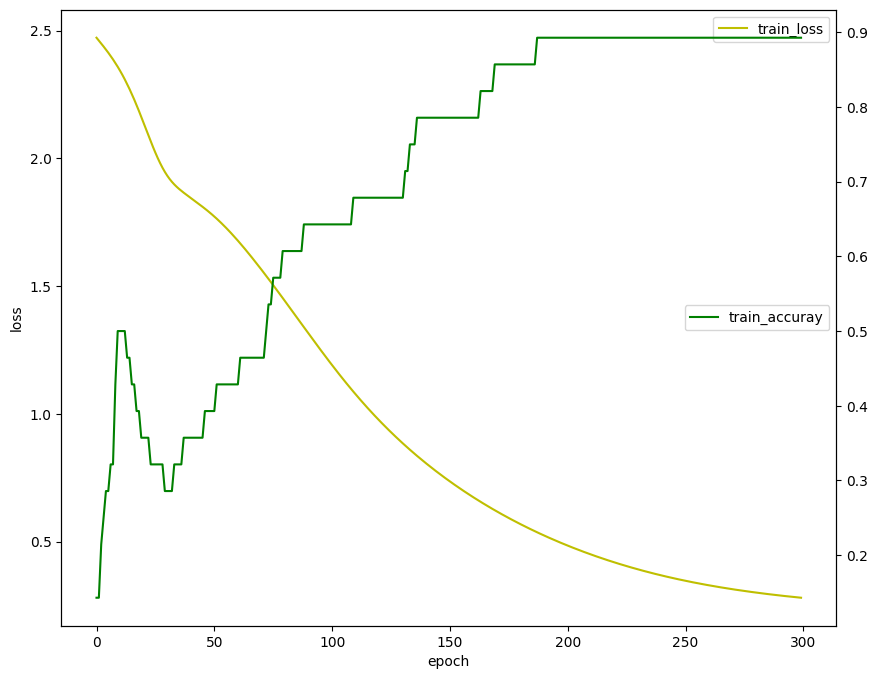

In [17]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,8))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x 축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuray')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='upper right')
acc_ax.legend(loc='center right')
plt.show()

In [18]:
# 모델사용하기 (경마장에 -> 있는)
encoded = t.texts_to_sequences(['경마장에'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data).argmax()
print('모델이 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break;

1/1 [==============================] - 0s 184ms/step
모델이 예측 결과 : 3
예측한 단어 : 있는


In [19]:
encoded = t.texts_to_sequences(['겨울은'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data).argmax()
result

1/1 [==============================] - 0s 17ms/step


1

In [20]:
# 모델사용하기 :사용자한테 입력받기
word = input('입력한단어는? :')
encoded = t.texts_to_sequences([word])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data).argmax()
print('모델이 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break;

입력한단어는? :겨울은
1/1 [==============================] - 0s 17ms/step
모델이 예측 결과 : 1
예측한 단어 : 말이


# 2. 다음 문맥 예측해보기

In [36]:
# "경마장에" 이후에 단어 4개의 문맥을 만들어줘
def sentence_generation(model, current_word, n):
    for i in range(1, n+1):
        print(i, "번째 current_word :", current_word)
        encoded = t.texts_to_sequences([current_word])
        input_data = pad_sequences(encoded, maxlen=my_len-1, padding='pre')
        result = model.predict(input_data, verbose=0).argmax()
        for word, index in t.word_index.items():
            if result==index:
                print('{}번째 예측 {} : {}'.format(i, result, word))
                current_word += f" {word}"
                break;
        
                

In [37]:
sentence_generation(model, '경마장에', 4)

1 번째 current_word : 경마장에
1번째 예측 3 : 있는
2 번째 current_word : 경마장에 있는
2번째 예측 1 : 말이
3 번째 current_word : 경마장에 있는 말이
3번째 예측 4 : 뛰고
4 번째 current_word : 경마장에 있는 말이 뛰고
4번째 예측 5 : 있다
